## **Conditional GAN**

In [20]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import math

In [21]:
def show(images, n_images, nrows, show=True):
  grid = make_grid(((images + 1) / 2).detach().cpu()[:n_images], nrow=nrows).permute(1,2,0).squeeze()
  plt.imshow(grid)
  if show:
    plt.show()

In [3]:
transform = transforms.Compose([
    # transforms.Resize(28),
    transforms.ToTensor(),
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    transforms.Normalize((0.5,), (0.5,))
])

In [4]:
dataset = datasets.MNIST('MNIST', train=True,
                         transform=transform, download=True)
data_loader = DataLoader(dataset, batch_size=128, shuffle=True)

In [5]:
for i, image in enumerate(data_loader):
  img = image[0]

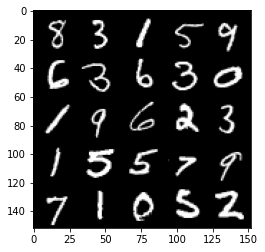

In [6]:
show(img, 25, 5)

## **Generator**

In [7]:
def generator_block(input, output, kernel_size=3, stride=2, last_layer=False):
  if not last_layer:
    x = nn.Sequential(
        nn.ConvTranspose2d(input, output, kernel_size, stride),
        nn.BatchNorm2d(output),
        nn.ReLU(inplace=True),
    )
  else:
    x = nn.Sequential(
        nn.ConvTranspose2d(input, output, kernel_size, stride),
        nn.Tanh(),
    )
  return x

In [8]:
class Generator(nn.Module):
  def __init__(self, noise_dim, image_dim, hidden_dim):
    super(Generator, self).__init__()
    self.noise_dim = noise_dim
    self.generator = nn.Sequential(
        generator_block(noise_dim, hidden_dim * 4),
        generator_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
        generator_block(hidden_dim * 2, hidden_dim),
        generator_block(hidden_dim, image_dim, kernel_size=4, last_layer=True)
    )

  def forward(self, noise):
    noise = noise.view(len(noise), self.noise_dim, 1, 1)
    x = self.generator(noise)
    return x

In [9]:
def get_noise_vectors(n_samples, noise_dim, device='cpu'):
  return torch.randn(n_samples, noise_dim, device=device)

## **Discriminator**

In [10]:
def discriminator_block(input, output, kernel_size=4, stride=2, last_layer=False):
  if not last_layer:
    x = nn.Sequential(
        nn.Conv2d(input, output, kernel_size, stride),
        nn.BatchNorm2d(output),
        nn.LeakyReLU(0.2, inplace=True),
    )
  else:
    x = nn.Sequential(
        nn.Conv2d(input, output, kernel_size, stride),
    )
  return x

In [11]:
class Discriminator(nn.Module):
  def __init__(self, image_dim, hidden_dim):
    super(Discriminator, self).__init__()
    self.discr = nn.Sequential(
        discriminator_block(image_dim, hidden_dim),
        discriminator_block(hidden_dim, hidden_dim * 2),
        discriminator_block(hidden_dim * 2, 1, last_layer=True)
    )

  def forward(self, image):
    x = self.discr(image)
    return x.view(len(x), -1)

## **One-hot encoding of image labels**

In [12]:
# This is how a one-hot encoded tensor looks like
# Assume this tensor has 10 classes like MNIST digits and
# 5 samples. Each 1 represents the respective digit

x = torch.nn.functional.one_hot(torch.arange(0,5), num_classes=10)
y = torch.randn(5, 10)
z = torch.cat((x.float(), y.float()), dim=1)

# The Concatenated vector of one-hot and random noise
print(z[0])

tensor([ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.6225, -1.6299,  0.3718,  0.7226,  1.1064,  0.1927,
        -0.6800,  0.8677,  0.0750,  0.8862])


In [13]:
def one_hot_encode(n_classes, labels):
  return torch.nn.functional.one_hot(labels, num_classes=n_classes)

## **Concatination one-hot encoding of image labels with noise vectors**

In [14]:
def concat_vectors(a, b):
  cat = torch.cat((a.float(), b.float()), 1)
  return cat

## **Training**

In [15]:
criterion = nn.BCEWithLogitsLoss()
epochs = 50
step = 500
batch_size = 128
lr = 0.0002
noise_dim = 64
device = 'cuda'

image_shape = (1,28,28)
classes = 10

image_channels = 1
hidden_dim_gen = 64
hidden_dim_discr = 64

In [16]:
def calculate_new_input_dims(image_shape, classes, noise_dim):
  discr_dim = image_shape[0] + classes
  gen_dim = noise_dim + classes
  return gen_dim, discr_dim

In [17]:
gen_dim, discr_dim = calculate_new_input_dims(image_shape, classes, noise_dim)

generator = Generator(gen_dim, image_channels, hidden_dim_gen).to(device)
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)
discriminator = Discriminator(discr_dim, hidden_dim_discr).to(device)
discr_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)

def init_weights(layer):
  if isinstance(layer, nn.ConvTranspose2d) or isinstance(layer, nn.Conv2d):
    torch.nn.init.normal_(layer.weight, 0.0, 0.02)
  if isinstance(layer, nn.BatchNorm2d):
    torch.nn.init.normal_(layer.weight, 0.0, 0.02)
    torch.nn.init.constant_(layer.bias, 0)

generator = generator.apply(init_weights)
discriminator = discriminator.apply(init_weights)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Generator loss: 4.483765242576599, discriminator loss: 0.03187130905408412


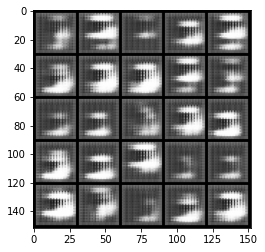

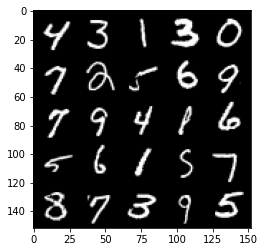

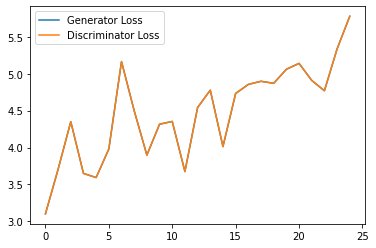

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 4.7871234970092775, discriminator loss: 0.03833175820764154


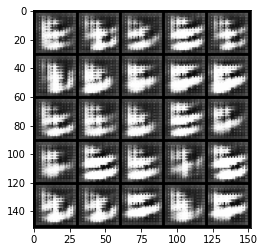

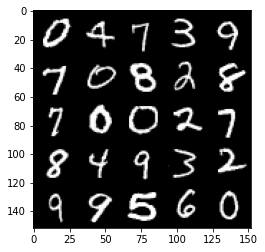

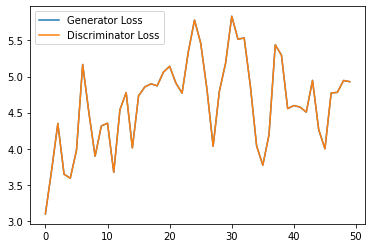

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1500: Generator loss: 5.3798038535118105, discriminator loss: 0.025089071035385133


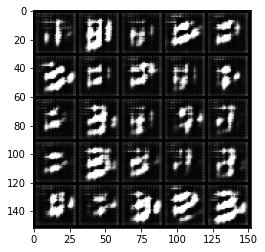

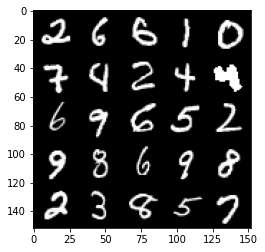

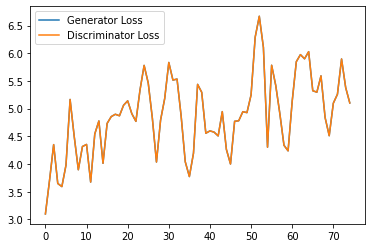

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Generator loss: 3.736525983810425, discriminator loss: 0.1086016988903284


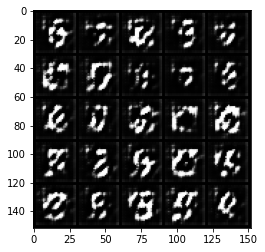

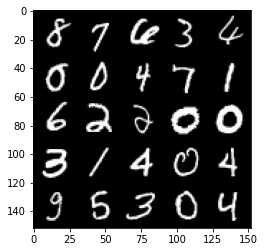

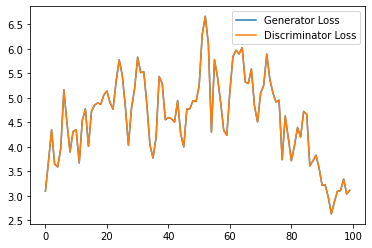

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2500: Generator loss: 2.727774393081665, discriminator loss: 0.23400331552326678


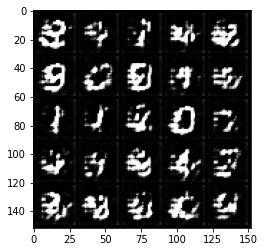

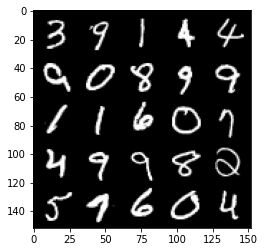

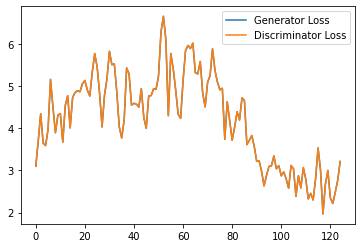

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000: Generator loss: 2.486496063232422, discriminator loss: 0.26586760422587397


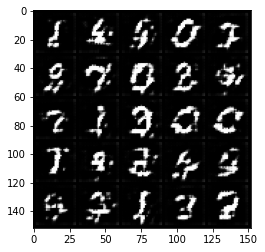

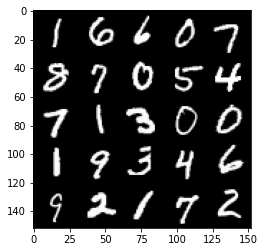

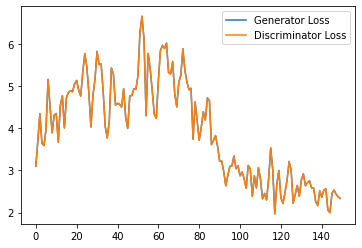

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3500: Generator loss: 2.326319134235382, discriminator loss: 0.2673554130643606


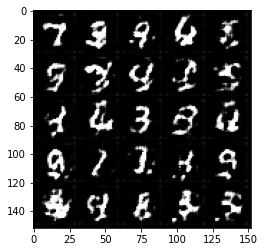

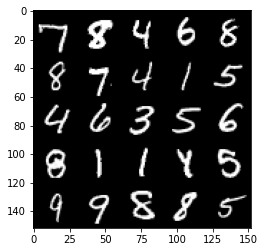

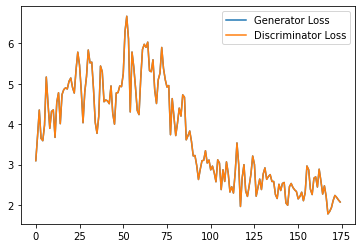

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4000: Generator loss: 2.1705460214614867, discriminator loss: 0.2832656910121441


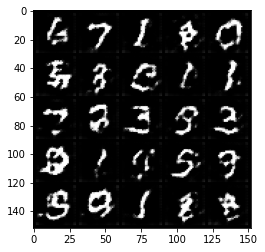

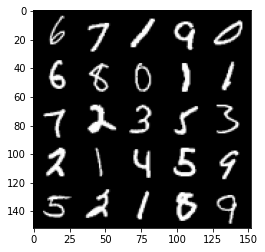

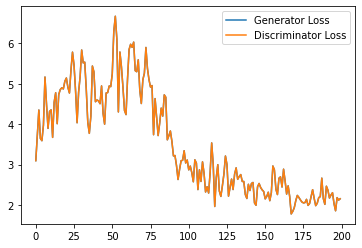

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4500: Generator loss: 2.3189757335186005, discriminator loss: 0.299260576069355


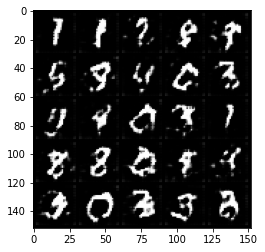

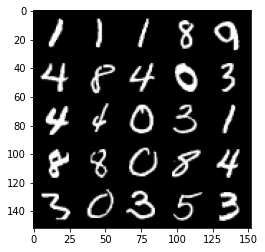

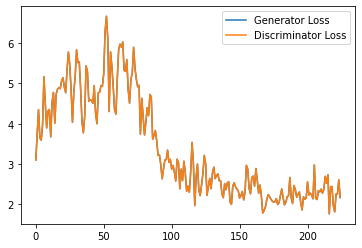

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5000: Generator loss: 2.0706174490451814, discriminator loss: 0.3466816824674606


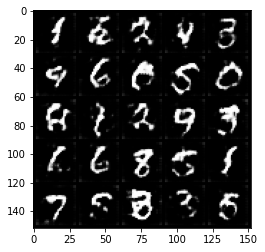

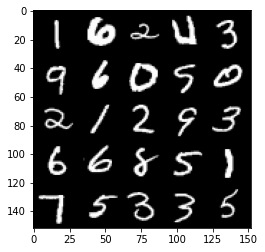

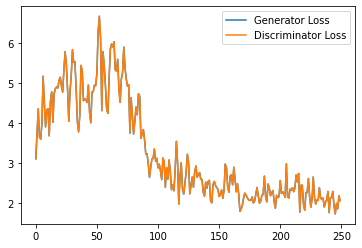

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5500: Generator loss: 1.9129870085716247, discriminator loss: 0.41019093933701517


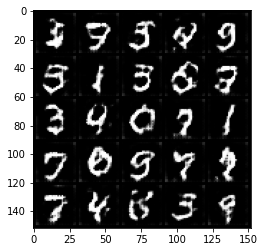

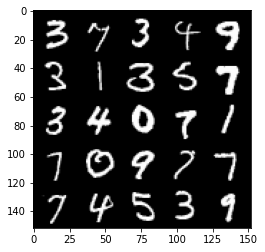

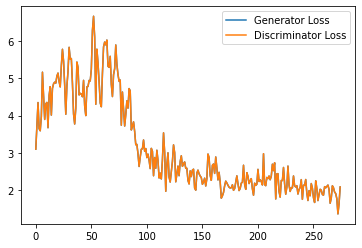

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6000: Generator loss: 1.673775666475296, discriminator loss: 0.4115937302410603


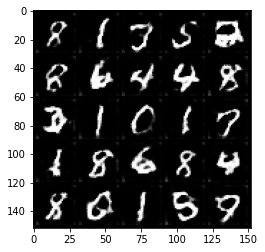

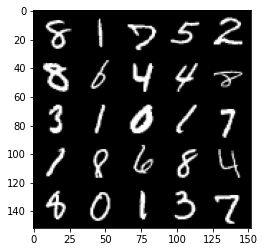

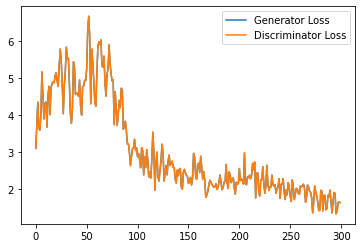

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6500: Generator loss: 1.5722756241559983, discriminator loss: 0.4235887500345707


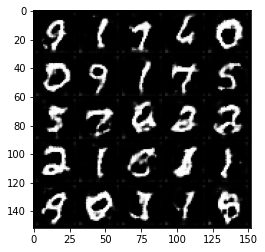

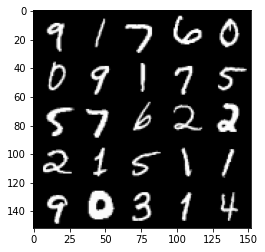

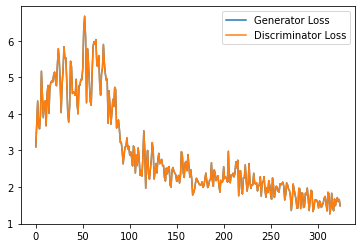

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7000: Generator loss: 1.625184921503067, discriminator loss: 0.4395408020019531


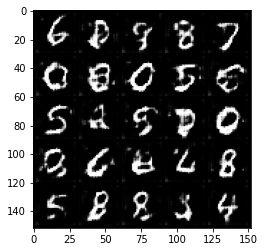

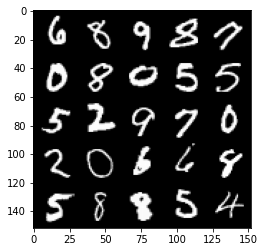

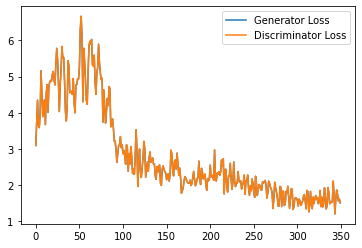

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7500: Generator loss: 1.639189007639885, discriminator loss: 0.4516805648803711


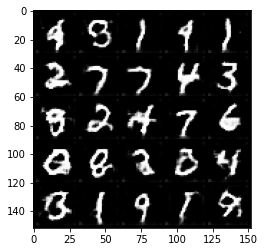

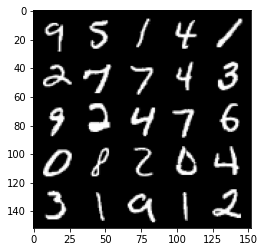

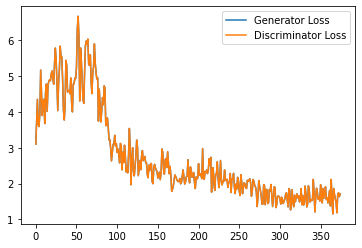

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8000: Generator loss: 1.5290122368335723, discriminator loss: 0.4738219347000122


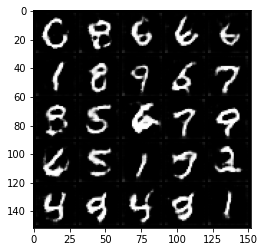

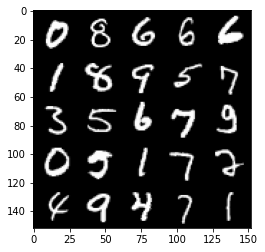

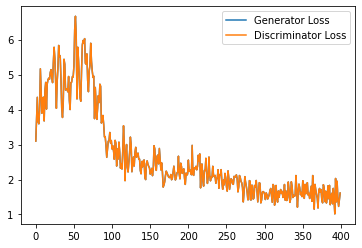

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8500: Generator loss: 1.4529383569955825, discriminator loss: 0.4824507169723511


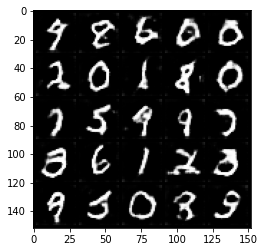

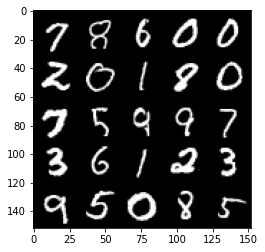

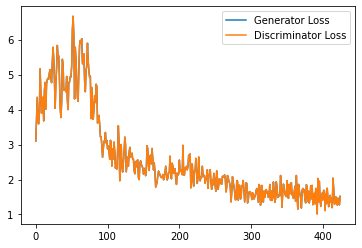

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9000: Generator loss: 1.432155290722847, discriminator loss: 0.48637030774354933


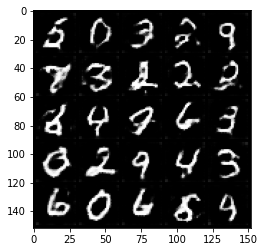

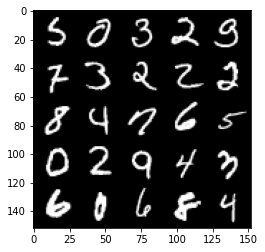

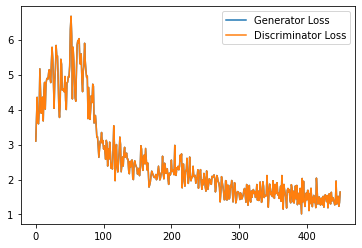

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9500: Generator loss: 1.3369921270608902, discriminator loss: 0.5054600232243538


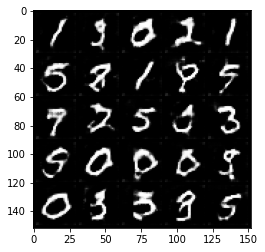

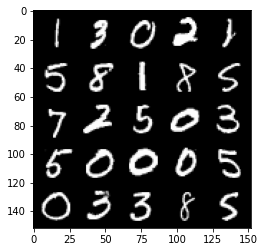

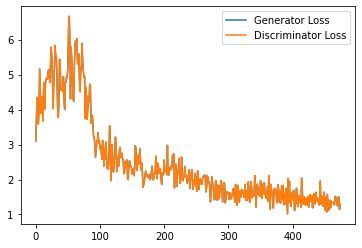

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10000: Generator loss: 1.3788233498334885, discriminator loss: 0.497185540497303


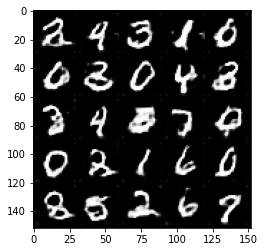

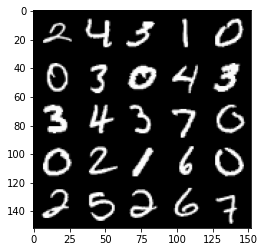

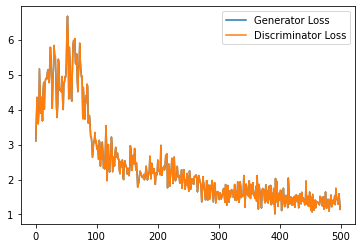

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10500: Generator loss: 1.3133950645923615, discriminator loss: 0.5026650856733322


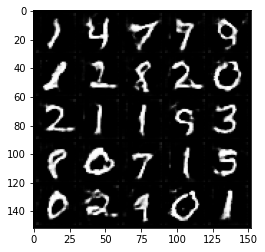

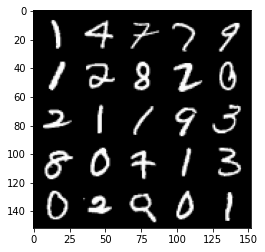

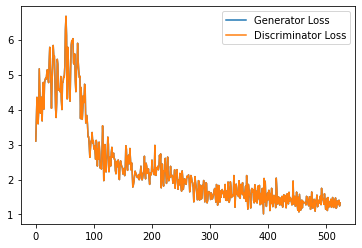

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11000: Generator loss: 1.3391430612802506, discriminator loss: 0.51579818546772


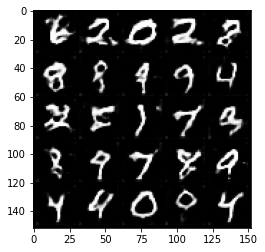

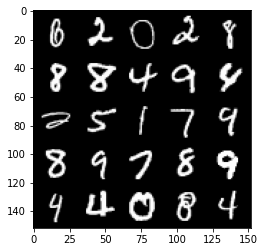

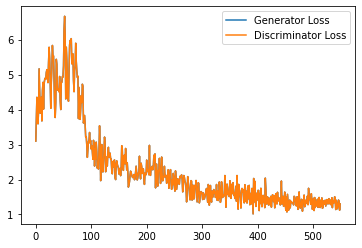

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11500: Generator loss: 1.2167721952199937, discriminator loss: 0.5305410655140876


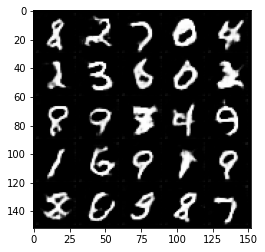

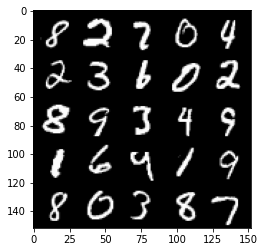

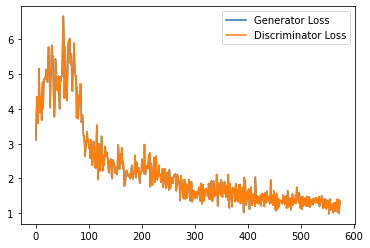

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12000: Generator loss: 1.2462947050333022, discriminator loss: 0.5485882869362831


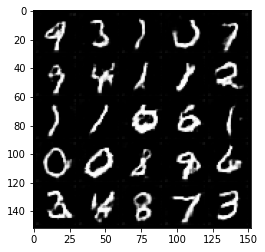

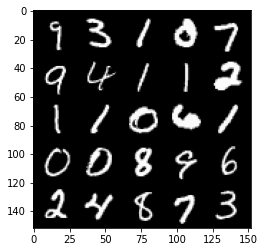

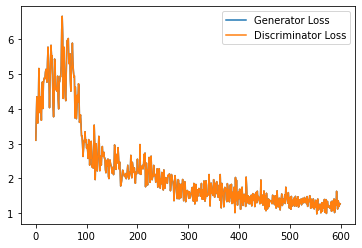

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12500: Generator loss: 1.2248111704587936, discriminator loss: 0.5430736768841743


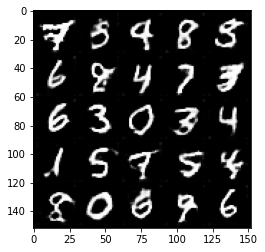

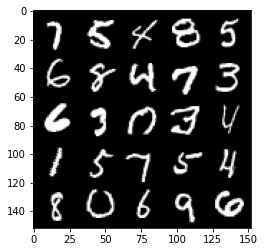

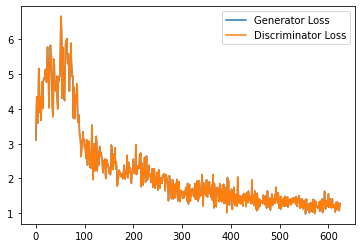

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13000: Generator loss: 1.1871126403808594, discriminator loss: 0.5544900661706924


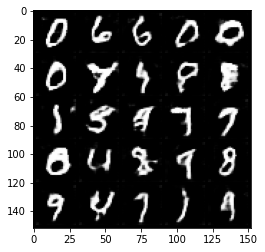

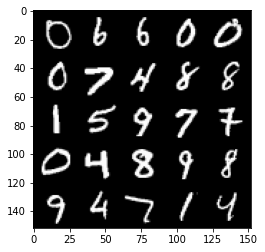

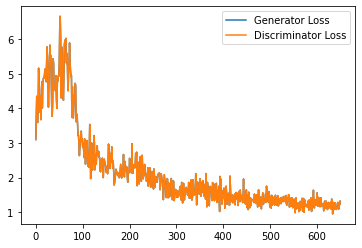

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13500: Generator loss: 1.1450604296922684, discriminator loss: 0.5662104178071022


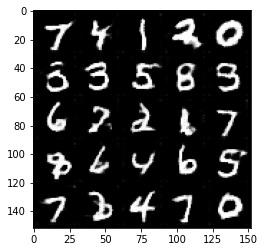

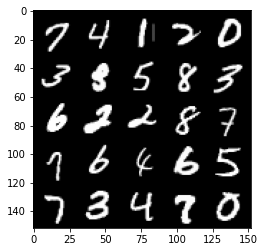

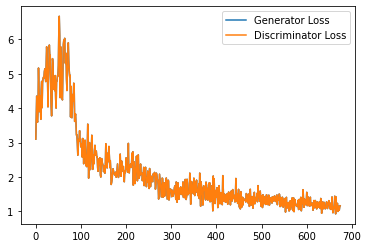

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14000: Generator loss: 1.139666998744011, discriminator loss: 0.5628599898219109


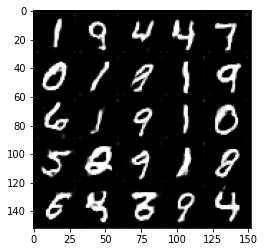

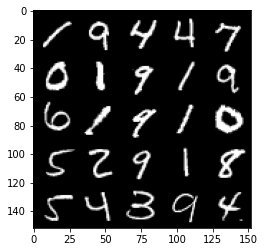

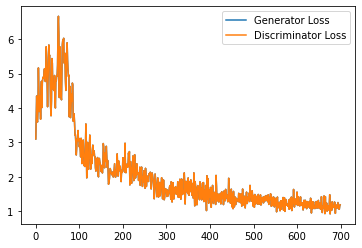

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14500: Generator loss: 1.1330062443017959, discriminator loss: 0.5741466936469078


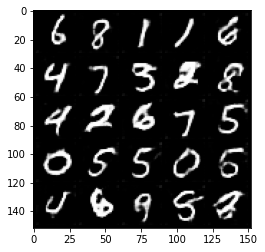

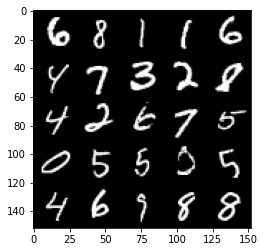

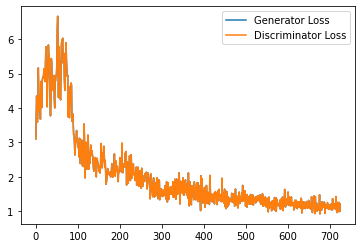

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15000: Generator loss: 1.1173213601112366, discriminator loss: 0.5710905860662461


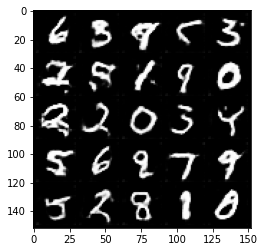

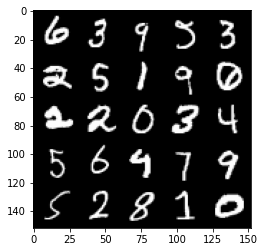

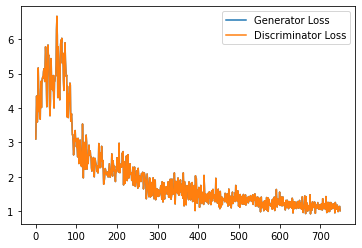

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15500: Generator loss: 1.1021079828739166, discriminator loss: 0.5695532339215279


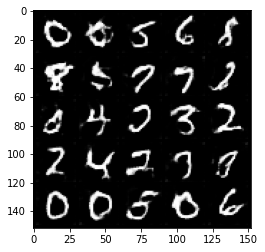

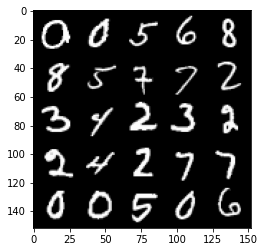

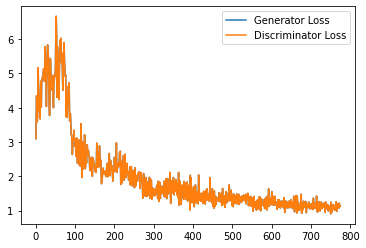

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16000: Generator loss: 1.1497312103509902, discriminator loss: 0.5814434695243835


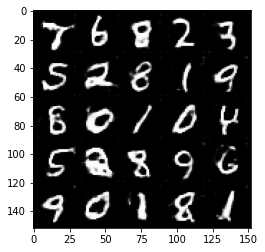

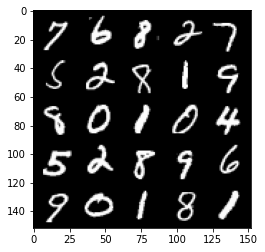

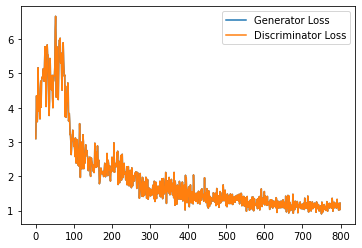

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16500: Generator loss: 1.0579945927858352, discriminator loss: 0.5820973353385925


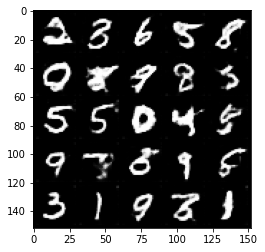

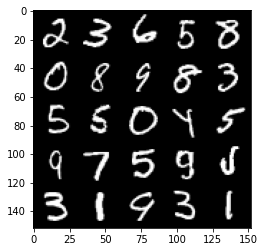

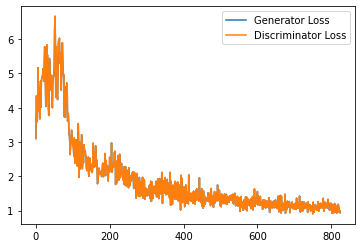

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17000: Generator loss: 1.1005081025362016, discriminator loss: 0.5781406996250152


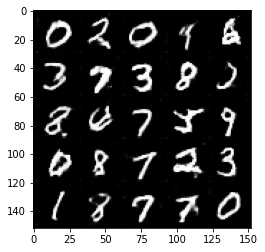

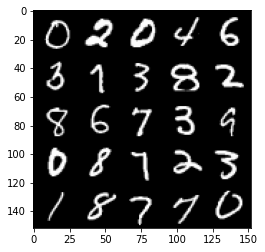

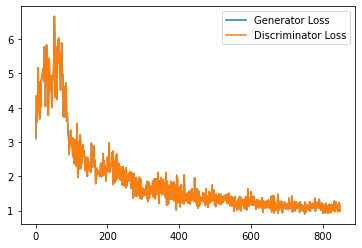

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17500: Generator loss: 1.0777615526914597, discriminator loss: 0.5713295459747314


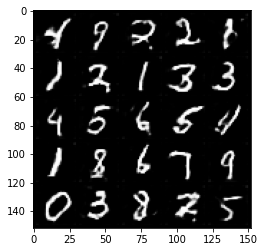

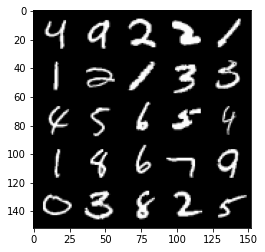

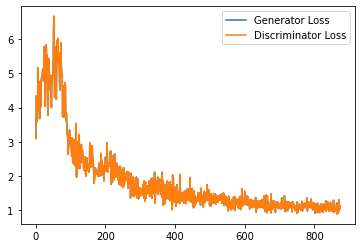

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18000: Generator loss: 1.0617818306684494, discriminator loss: 0.5815322050452232


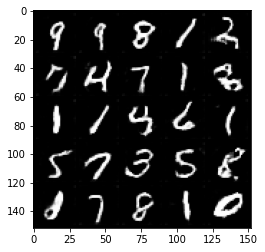

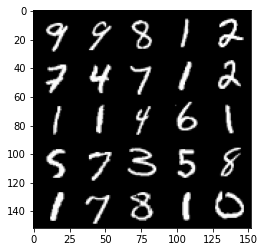

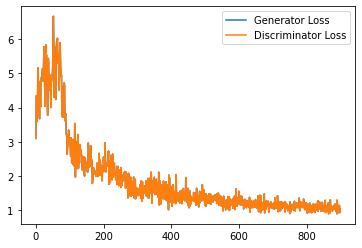

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18500: Generator loss: 1.0497978410720825, discriminator loss: 0.581303129196167


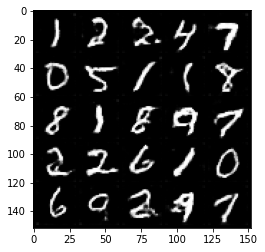

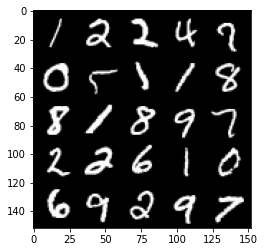

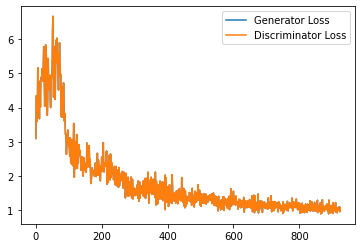

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19000: Generator loss: 1.0537910112142563, discriminator loss: 0.5731645288467407


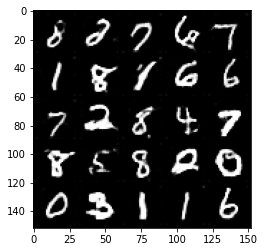

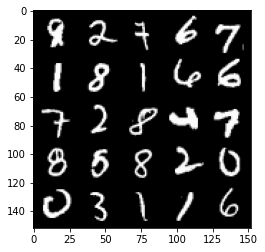

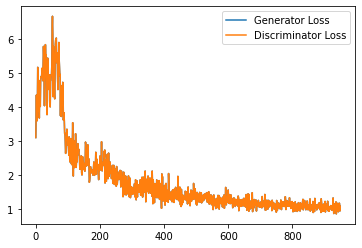

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19500: Generator loss: 1.0826624299287797, discriminator loss: 0.5869855357408523


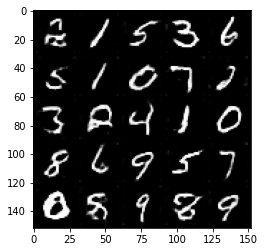

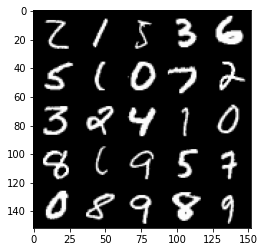

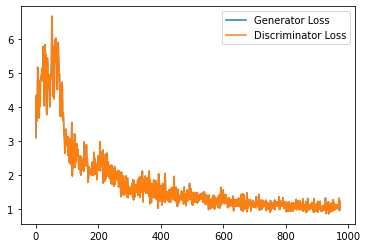

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20000: Generator loss: 1.08397188103199, discriminator loss: 0.5853244336247444


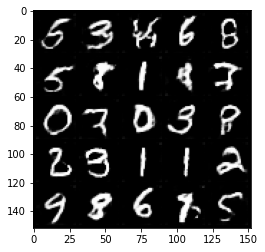

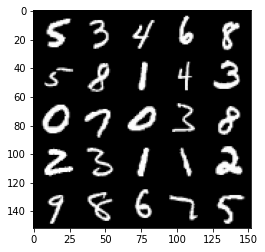

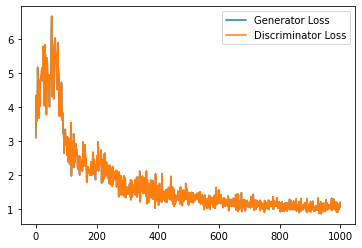

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20500: Generator loss: 1.0366509639024735, discriminator loss: 0.5830229312181473


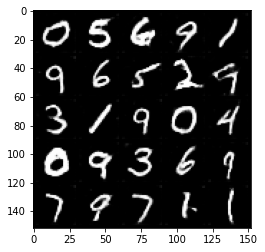

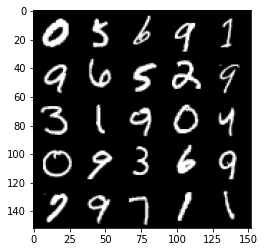

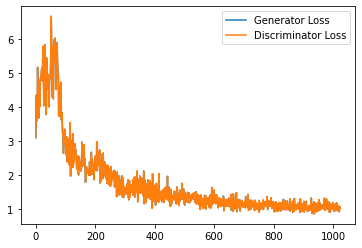

  0%|          | 0/469 [00:00<?, ?it/s]

Step 21000: Generator loss: 1.0200897384881973, discriminator loss: 0.5838460098505021


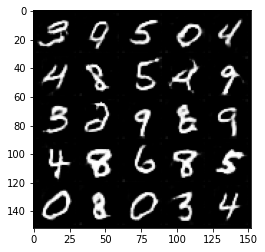

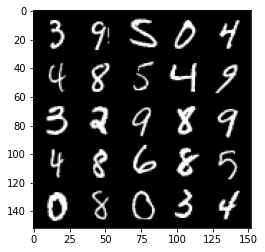

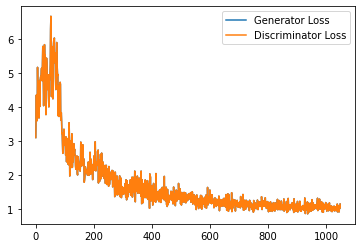

  0%|          | 0/469 [00:00<?, ?it/s]

Step 21500: Generator loss: 1.0364941734075546, discriminator loss: 0.5931773255467415


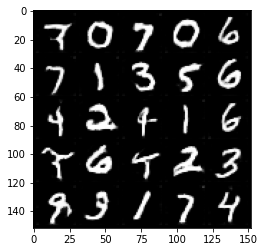

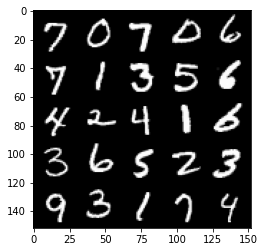

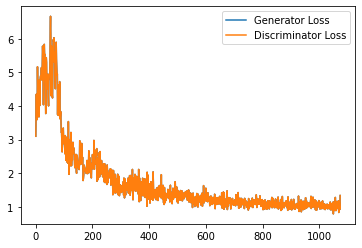

  0%|          | 0/469 [00:00<?, ?it/s]

Step 22000: Generator loss: 1.0255012934207917, discriminator loss: 0.5919324515461921


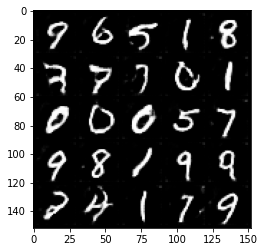

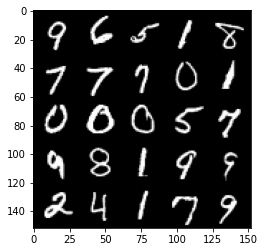

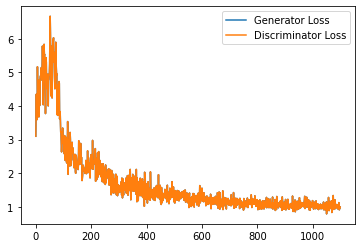

  0%|          | 0/469 [00:00<?, ?it/s]

Step 22500: Generator loss: 1.002646609544754, discriminator loss: 0.5944191415905953


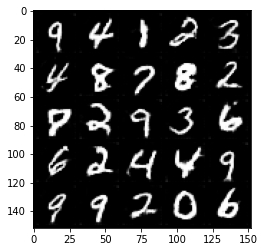

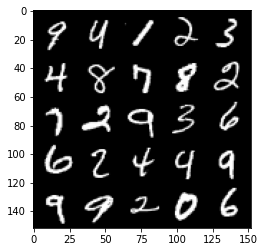

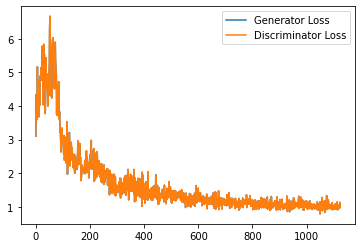

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 23000: Generator loss: 1.054962755560875, discriminator loss: 0.597278164088726


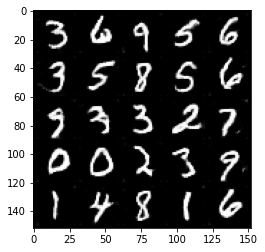

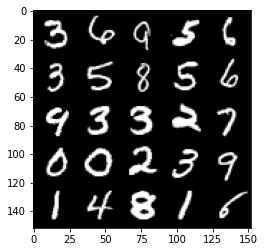

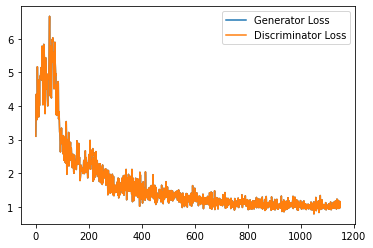

In [19]:
cur_step = 0
gen_losses = []
discr_losses = []

for epoch in range(epochs):
  for image, label in tqdm(data_loader):
    cur_batch_size = len(image)
    image = image.to(device)

    # For Generator
    one_hot_labels = one_hot_encode(classes, label.to(device))
    image_one_hot_labels = one_hot_labels[:, :, None, None]
    # For Discriminator
    image_one_hot_labels = image_one_hot_labels.repeat(1, 1, image_shape[1], image_shape[2])

    # Update Discriminator
    discr_optimizer.zero_grad()
    fake_noise = get_noise_vectors(cur_batch_size, noise_dim, device=device)

    noise_cat_labels = concat_vectors(fake_noise, one_hot_labels)
    fake = generator(noise_cat_labels)

    fake_image_cat_labels = concat_vectors(fake, image_one_hot_labels)
    real_image_cat_labels = concat_vectors(image, image_one_hot_labels)
    discr_fake_pred = discriminator(fake_image_cat_labels.detach())
    discr_real_pred = discriminator(real_image_cat_labels)

    discr_fake_loss = criterion(discr_fake_pred, torch.zeros_like(discr_fake_pred))
    discr_real_loss = criterion(discr_real_pred, torch.ones_like(discr_real_pred))
    discr_loss = (discr_fake_loss + discr_real_loss) / 2
    discr_loss.backward(retain_graph=True)
    discr_optimizer.step()
    discr_losses += [discr_loss.item()]

    # Update Generator
    gen_optimizer.zero_grad()

    fake_image_cat_labels = concat_vectors(fake, image_one_hot_labels)
    discr_fake_pred = discriminator(fake_image_cat_labels)
    gen_loss = criterion(discr_fake_pred, torch.ones_like(discr_fake_pred))
    gen_loss.backward()
    gen_optimizer.step()

    gen_losses += [gen_loss.item()]

    if cur_step % step == 0 and cur_step > 0:
            gen_mean = sum(gen_losses[-step:]) / step
            disc_mean = sum(discr_losses[-step:]) / step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
            show(fake, 25, 5)
            show(image, 25, 5)
            step_bins = 20
            x_axis = sorted([i * step_bins for i in range(len(gen_losses) // step_bins)] * step_bins)
            num_examples = (len(gen_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(gen_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(gen_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Discriminator Loss"
            )
            plt.legend()
            plt.show()
    cur_step += 1

## **Changing the Noise vector and holding the class vector constant**

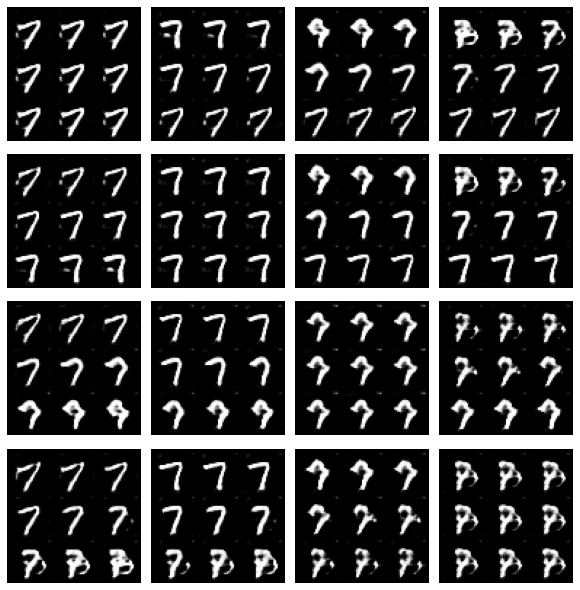

In [35]:
n = 9
digit = 7
interpolation_label = one_hot_encode(classes, torch.Tensor([digit]).long()).repeat(n, 1).float()

def interpolate_noise(a, b):
  first_noise_ratio = torch.linspace(0, 1, n)[:, None].to(device)
  noise = a * first_noise_ratio + b * (1 - first_noise_ratio)

  noise_cat_labels = concat_vectors(noise, interpolation_label.to(device))
  fake = generator(noise_cat_labels)
  show(fake, n, int(math.sqrt(n)), show=False)

n_noise = 4
plot = [get_noise_vectors(1, noise_dim, device=device) for i in range(n_noise)]
plt.figure(figsize=(8,8))
for i, plot_noise_first in enumerate(plot):
  for j, plot_noise_second in enumerate(plot):
    plt.subplot(n_noise, n_noise, i * n_noise + j + 1)
    interpolate_noise(plot_noise_first, plot_noise_second)
    plt.axis('off')
plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.1, wspace=0)
plt.show()
plt.close()